# Multi Layer Perceptron

パーセプトロンを複数レイヤーつなげて、学習させてみる。活性化関数としては、reluを使い、最後の評価は`L.Classifier`のデフォルトで使うことにする。最適化アルゴリズムはAdamを使う。

In [39]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

In [40]:
import pickle, gzip
f = gzip.open('../data/mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
print(len(train_set[0]), len(valid_set[0]), len(test_set[0]))
train_set_x, train_set_y  = train_set
test_set_x, test_set_y = test_set
print(len(train_set_x[0]))
print(train_set_x)
print("28x28の画像のモノクロ(白0→黒1)が１次元配列で入っている",train_set_x[:5])
print("最初のラベルは",train_set_y[0])

# あとで、softmax_cross_entropyを使うときに型の判定があり、np.int32じゃないといけない
train_set_y = train_set_y.astype(np.int32)
test_set_y = test_set_y.astype(np.int32)
print(train_set_y )
f.close()

50000 10000 10000
784
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
28x28の画像のモノクロ(白0→黒1)が１次元配列で入っている [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
最初のラベルは 5
[5 0 4 ..., 8 4 8]


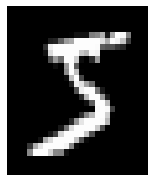

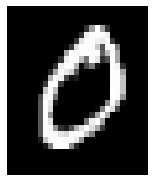

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
def draw_digit(data):
    size = 28
    plt.figure(figsize=(2.5, 3))

    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

    plt.show()

draw_digit(train_set_x[0])
draw_digit(train_set_x[1])

In [16]:
class MNISTMLPerceptron(Chain):
    def __init__(self, hidden_num=1024):
        super(MNISTMLPerceptron, self).__init__(
            l1 = L.Linear(784, hidden_num),
            l2 = L.Linear(hidden_num, hidden_num),
            l3 = L.Linear(hidden_num, 10)
        )
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)
    
model = L.Classifier(MNISTMLPerceptron())

In [6]:
optimizer = optimizers.Adam()
optimizer.setup(model)

batch_size = 100
for step in range(1001):
    batch_index = np.random.randint(len(train_set[0])-batch_size)
    batch_x = Variable(train_set_x[batch_index:batch_index+batch_size])
    batch_y = Variable(train_set_y[batch_index:batch_index+batch_size])
    optimizer.update(model, batch_x, batch_y)
    if step % 100 == 0:
        print(step, model.accuracy.data)
    

0 0.9599999785423279
100 0.9700000286102295
200 0.9900000095367432
300 1.0
400 0.9900000095367432
500 0.9800000190734863
600 0.949999988079071
700 0.9700000286102295
800 0.9599999785423279
900 0.9700000286102295


In [7]:
model(Variable(test_set_x),Variable(test_set_y))
print(model.accuracy.data)

0.9740999937057495


97%ぐらいの制度が出る

次は、各層にdropoutを入れてみる

In [35]:
class MNISTMLPerceptronDropout(MNISTMLPerceptron):
    def __call__(self, x):
        h1 = F.dropout(F.relu(self.l1(x)))
        h2 = F.dropout(F.relu(self.l2(h1)))
        return self.l3(h2)

In [36]:
model = L.Classifier(MNISTMLPerceptronDropout())
optimizer.setup(model)
batch_size = 100
for step in range(1001):
    batch_index = np.random.randint(len(train_set[0])-batch_size)
    batch_x = Variable(train_set_x[batch_index:batch_index+batch_size])
    batch_y = Variable(train_set_y[batch_index:batch_index+batch_size])
    optimizer.update(model, batch_x, batch_y)
    if step % 100 == 0:
        print(step, model.accuracy.data)

0 0.09000000357627869
100 0.8799999952316284
200 0.9399999976158142
300 0.9399999976158142
400 0.9599999785423279
500 0.949999988079071
600 0.8799999952316284
700 0.949999988079071
800 0.9100000262260437
900 0.9100000262260437
1000 0.9599999785423279


In [37]:
model(Variable(test_set_x),Variable(test_set_y))
print(model.accuracy.data)

0.9541000127792358
